In [4]:
cd ~/Desktop/workbench/cs330-final

/Users/gautam/Desktop/workbench/cs330-final


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import itertools

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

import datasets
import model
import utils
import train

/Users/gautam/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Measuring Task Correlation

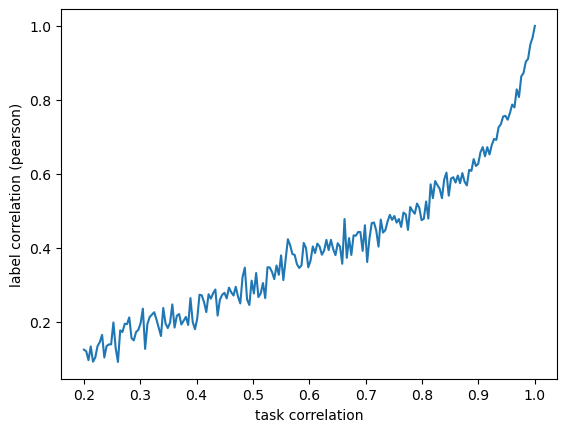

In [122]:
rs = []
ps = np.linspace(0.2, 1, 200)
for p in ps:
    x, y = utils.generate_task_pairs(1, 1000, dim=128, relatedness=p, c=1., m=6, noise_std=0.01)
    y1, y2 = y
    y1 = (y1 - y1.mean()) / y1.std()
    y2 = (y2 - y2.mean()) / y2.std()
    r = np.sum((y1 - np.mean(y1)) * (y2 - np.mean(y2))) / np.sqrt(np.sum((y1 - np.mean(y1))**2)*np.sum((y2 - np.mean(y2))**2))
    rs.append(r)

plt.xlabel('task correlation')
plt.ylabel('label correlation (pearson)')
plt.plot(ps, rs)

## Task Setup
Setup datasets, loss functions, etc.

In [179]:
bs = 256
p = 0.
lr = 1e-4

# p = 1.
# lr = 1e-4

In [180]:
x, y = utils.generate_task_pairs(1, 50000, dim=128, relatedness=p, c=1., m=6, noise_std=0.01)
x = x.astype(np.float32)
y = y.astype(np.float32)
x = (torch.tensor(x))
y = (torch.tensor(y))
y1, y2 = y
y1 = (y1 - y1.mean()) / y1.std()
y2 = (y2 - y2.mean()) / y2.std()
n_train = 40000

mnist_train = list(zip(x[:n_train], y1[:n_train]))
fmnist_train = list(zip(x[:n_train], y2[:n_train]))

mnist_val = list(zip(x[n_train:], y1[n_train:]))
fmnist_val = list(zip(x[n_train:], y2[n_train:]))

mnist_train_loader = DataLoader(mnist_train, batch_size=bs, shuffle=True, drop_last=True)
fmnist_train_loader = DataLoader(fmnist_train, batch_size=bs, shuffle=True, drop_last=True)

mnist_iter = itertools.cycle(mnist_train_loader)
fmnist_iter = itertools.cycle(fmnist_train_loader)

tasks = {
    'mnist': {
        'train_iter': mnist_iter,
        'eval_ds': mnist_val,
        'loss': lambda logits, labels: F.mse_loss(logits, labels),
        'predict': lambda logits: logits,
        'metric': lambda yh, y: F.mse_loss(yh, y).detach().numpy(),
    },
    'fashion_mnist': {
        'train_iter': fmnist_iter,
        'eval_ds': fmnist_val,
        'loss': lambda logits, labels: F.mse_loss(logits, labels),
        'predict': lambda logits: logits,
        'metric': lambda yh, y: F.mse_loss(yh, y).detach().numpy(),
    },
}

## Compute gradient alignments

In [181]:
import copy

class SharedMTL(nn.Module):
    def __init__(self, task_keys):
        super().__init__()
        self.backbone = model.LinearBackbone()
        x = nn.Linear(256, 1)
        self.heads = nn.ModuleDict({
            task: copy.deepcopy(x)
            for task in task_keys
        })
    
    def forward(self, x, task):
        return self.heads[task](self.backbone(x)).view(-1) 

shared_mtl = SharedMTL(tasks.keys())
grads, loss, rgn = train.get_gradients(
    model=shared_mtl,
    tasks=tasks, 
    steps=100, 
    lr=lr,
)

100%|█████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 110.55it/s]


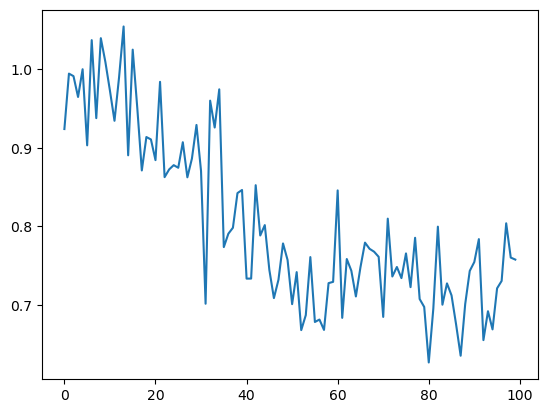

In [182]:
# grads[0]['mnist']['backbone.net.0.weight'], grads[0]['fashion_mnist']['backbone.net.0.weight']

plt.plot([np.mean(list(v.values())) for v in loss])

['backbone.net.0.weight', 'backbone.net.0.bias', 'backbone.net.2.weight', 'backbone.net.2.bias', 'backbone.net.4.weight', 'backbone.net.4.bias']


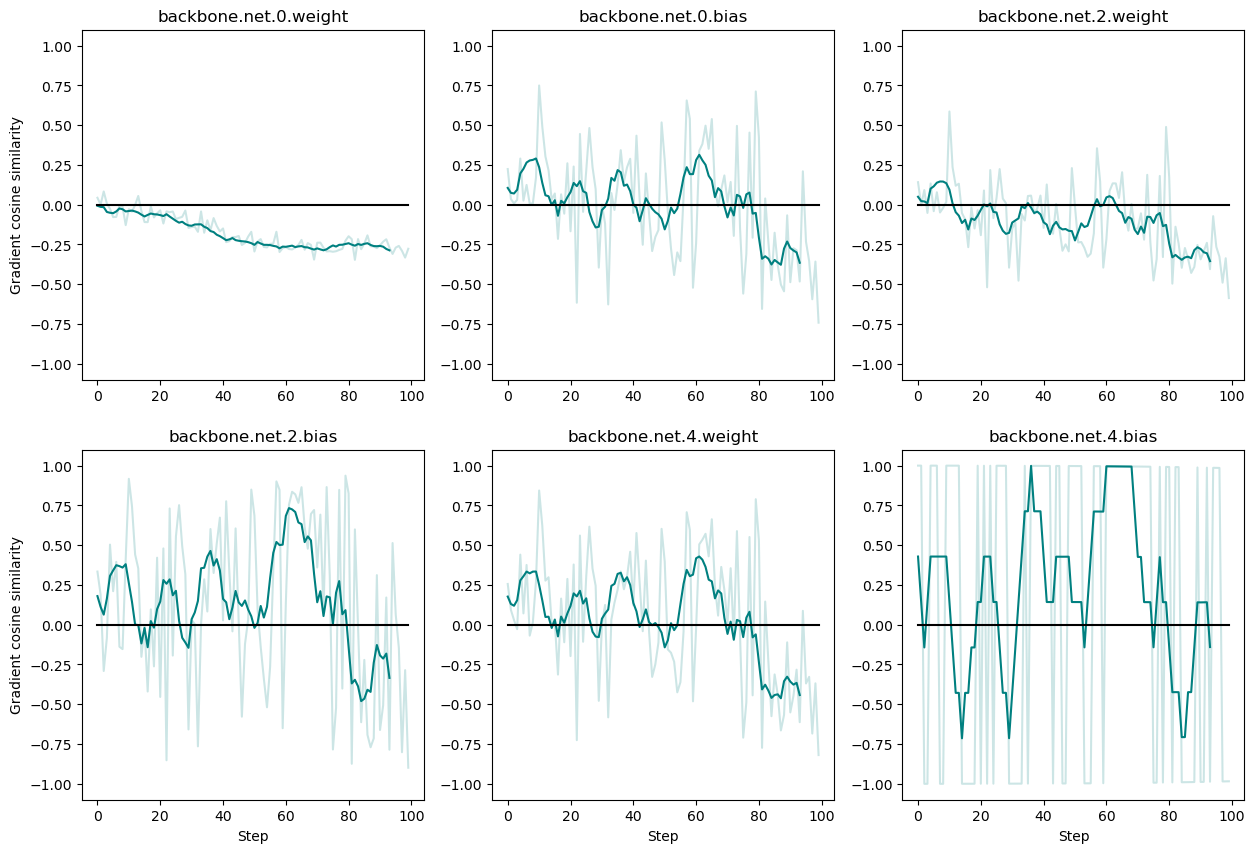

In [183]:
param_keys = ['backbone.' + k for k in list(shared_mtl.backbone.state_dict().keys())]
print(param_keys)

heuristic_results = {}

# plots
n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, key in enumerate(param_keys):
    # get gradients
    g0 = utils.stack_grad(grads, 'mnist', key)
    g1 = utils.stack_grad(grads, 'fashion_mnist', key)
        
    # heuristics computations
    cosine = torch.sum(F.normalize(g0, dim=-1) * F.normalize(g1, dim=-1), dim=-1)
    smooth_cos = utils.low_pass_filter(cosine[None], filter_size=7)[0][0]    
    avg_smoothed_cos = smooth_cos.mean()
    std_cos = cosine.std()
    
    g0_norm = np.linalg.norm(g0, axis=-1)
    g1_norm = np.linalg.norm(g1, axis=-1)
    mag_sim = (2 * g0_norm * g1_norm) / (g0_norm ** 2 + g1_norm ** 2)
    mag_sim_smoothed = utils.low_pass_filter(mag_sim[None], filter_size=20)[0][0]
    
    fh = mag_sim * cosine.numpy()
    fh_smoothed = utils.low_pass_filter(fh[None], filter_size=10)[0][0]
    
    heuristic_results[key] = {'avg_cos': avg_smoothed_cos, 
                              'std_cos': std_cos}
      
    # plot
    row, col = i // n_cols, i % n_cols
    ax = axes[row][col]    
    
    if avg_smoothed_cos >= 0:
        ax.set_title(key)#, color='green')
    else:
        ax.set_title(key)
    if col == 0:
        ax.set_ylabel('Gradient cosine similarity')
    if row == n_rows - 1:
        ax.set_xlabel('Step')
    ax.set_ylim([-1.1, 1.1])
    ax.plot(cosine, color='teal', alpha=0.2)
    ax.plot(smooth_cos, color='teal')
    ax.plot(np.zeros_like(cosine), color='black')
    # ax.plot(mag_sim, color='purple', alpha=0.2)
    # ax.plot(mag_sim_smoothed, color='purple')
    # ax.plot(r0 - r1)

    # ax.plot(fh_smoothed, color='cyan')

In [184]:
heuristic_results

{'backbone.net.0.weight': {'avg_cos': -0.18110022, 'std_cos': tensor(0.1052)},
 'backbone.net.0.bias': {'avg_cos': 0.011743223, 'std_cos': tensor(0.3397)},
 'backbone.net.2.weight': {'avg_cos': -0.097635195, 'std_cos': tensor(0.2251)},
 'backbone.net.2.bias': {'avg_cos': 0.14692071, 'std_cos': tensor(0.5313)},
 'backbone.net.4.weight': {'avg_cos': 0.04926826, 'std_cos': tensor(0.4068)},
 'backbone.net.4.bias': {'avg_cos': 0.21519819, 'std_cos': tensor(0.9804)}}

## Experiments

In [172]:
mtl = SharedMTL(tasks.keys())
fully_shared_exp = train.train_and_evaluate(
    model=mtl,
    tasks=tasks,
    steps=500,
    lr=lr,
    eval_every=50,
)

100%|█████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 180.92it/s]


In [173]:
class SeparateMTL(nn.Module):
    def __init__(self, task_keys):
        super().__init__()
        self.backbones = nn.ModuleDict({
            task: model.LinearBackbone()
            for task in task_keys
        })
        self.heads = nn.ModuleDict({
            task: nn.Linear(256, 1)
            for task in task_keys
        })
    
    def forward(self, x, task):
        return self.heads[task](self.backbones[task](x)).view(-1)

mtl = SeparateMTL(tasks.keys())
separate_exp = train.train_and_evaluate(
    model=mtl,
    tasks=tasks,
    steps=500,
    lr=lr,
    eval_every=50,
)

100%|█████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 150.19it/s]


In [161]:
class SurgicalMTL(nn.Module):
    def __init__(self, task_keys):
        super().__init__()
        self.backbone = model.Shareable(
            mdl=model.LinearBackbone(),
            task_keys=list(task_keys),
            shared_params=['net.4.bias']
        )
        self.heads = nn.ModuleDict({
            task: nn.Linear(256, 1)
            for task in task_keys
        })
    
    def forward(self, x, task):
        return self.heads[task](self.backbone(x, task)).view(-1)

mtl = SurgicalMTL(tasks.keys())
surgical_exp = train.train_and_evaluate(
    model=mtl,
    tasks=tasks,
    steps=500,
    lr=lr,
    eval_every=50,
)

100%|█████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 139.16it/s]


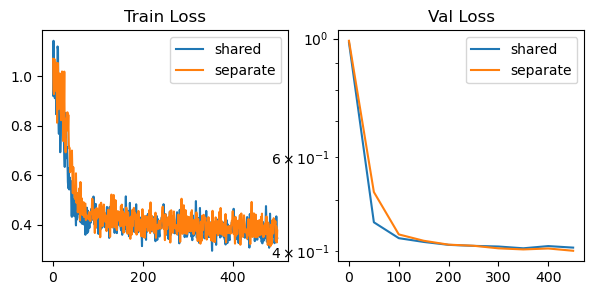

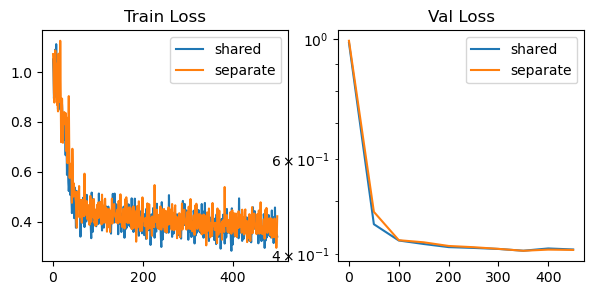

In [174]:
for task_name in tasks:
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))

    for exp_name, exp in [
        ('shared', fully_shared_exp),
        ('separate', separate_exp),
        # ('surgical', surgical_exp),
    ]:
        losses, metrics, eval_losses, eval_metrics = exp
        
        tl = [(s, l[task_name]) for s, l in losses]
        el = [(s, l[task_name]) for s, l in eval_losses]
        tm = [(s, m[task_name]) for s, m in metrics]
        em = [(s, m[task_name]) for s, m in eval_metrics]
    
        # plot
        ax = axes[0]
        tl_x, tl_y = zip(*tl)
        ax.plot(tl_x, tl_y, label=f'{exp_name}')#_{task_name}')
        ax.set_title('Train Loss')
        # ax.set_yscale('log')
        ax.legend()

        ax = axes[1]
        el_x, el_y = zip(*el)
        ax.plot(el_x, el_y, label=f'{exp_name}')#_{task_name}')
        ax.set_title('Val Loss')
        ax.set_yscale('log')
        ax.legend()

In [175]:
avg_loss = {'shared': [], 'separate': [], 'surgical': []}


for task_name in tasks:
    # fig, axes = plt.subplots(1, 2, figsize=(7, 3))

    for exp_name, exp in [
        ('shared', fully_shared_exp),
        ('separate', separate_exp),
        # ('surgical', surgical_exp),
    ]:
        losses, metrics, eval_losses, eval_metrics = exp
        
        tl = [l[task_name] for s, l in losses]
        el = [l[task_name] for s, l in eval_losses]
        tm = [(s, m[task_name]) for s, m in metrics]
        em = [(s, m[task_name]) for s, m in eval_metrics]
    
        avg_loss[exp_name].append(el)
        
    


In [178]:
RUN_NAME = 'p1-synth.pkl'

sh = np.array(avg_loss['shared']).mean(axis=0)
se = np.array(avg_loss['separate']).mean(axis=0)
# su = np.array(avg_loss['surgical']).mean(axis=0)
steps = list(range(0, 500, 50))

# import pickle
# with open(RUN_NAME, 'wb') as f:
#     pickle.dump((sh, se, su, steps), f)

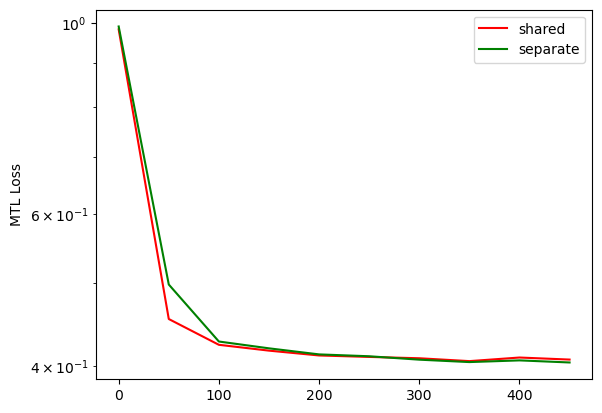

In [177]:
# plot
ax = axes[0]
plt.plot(steps, sh, label=f'shared', color='red')#_{task_name}')
plt.plot(steps, se, label=f'separate', color='green')#_{task_name}')
# plt.plot(steps, su, label=f'surgical', color='blue')#_{task_name}')
plt.ylabel('MTL Loss')
plt.yscale('log')
plt.legend()